<a href="https://colab.research.google.com/github/tmorshed/dbs_cep/blob/cortical/cep_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing cortical evoked potentials (cEPs) in STN-DBS
#### by Taha Morshedzadeh. **Krembil Research Institute, UHN. Toronto, Canada**

*This work is done as a part of the HMB496 "Independent Project in Human Biology" i.e. undergraduate thesis at the University of Toronto during Fall-Winter semesters of the 2019-20 year.*




In this Jupyter, we will try to estimate the cortical evoked potentials using EEG as a result of Deep Brain Stimulation in the Subthalamic Nucleus (STN). We will use the package `mne` from the Martinos Centre found at [this link](https://mne.tools). This package automatically sets matplotlib to `Qt` but since we are on Colab and it does not yet support `Qt`, we make it `inline` so that it appears as any other normal output in the notebook below the code snippet.


![MNE](https://mne.tools/stable/_static/mne_logo.png)

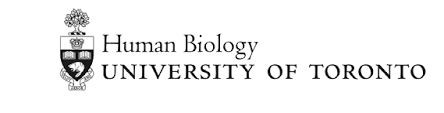


In [222]:
!pip install mne

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### a) import packages and files:

In [0]:
  #import os
    
%reset -sf

import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy.signal as sg
from datetime import datetime

%matplotlib inline

In [0]:
raw = mne.io.read_raw_cnt(r"/content/drive/My Drive/research/nsbspl/data/130Hz_STN_OFF_LeftSTIM.cnt", preload=False)
#preload=True makes it load to RAM as well. Normally, it only loads the symlinks to the RAM and the data stays in the local storage

In [225]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: L0, L1, L2, L3, R0, R1, R2, R3, FT7, FC5, FC3, FC1, FCZ, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: 2018-09-03 12:33:57 UTC
 nchan: 59
 projs: []
 sfreq: 5000.0 Hz
 subject_info: 5 items (dict)
>

the imported data object has 913600 time samples and 59 channels.
The last time sample is at 182.7198 seconds.

sampling frequency is 5000.0
MISC INFO: None
<Info | 8 non-empty values
 bads: []
 ch_names: L0, L1, L2, L3, R0, R1, R2, R3, FT7, FC5, FC3, FC1, FCZ, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2500.0 Hz
 meas_date: 2018-09-03 12:33:57 UTC
 nchan: 59
 projs: []
 sfreq: 5000.0 Hz
 subject_info: 5 items (dict)
>




The sensor locations on the cranium:


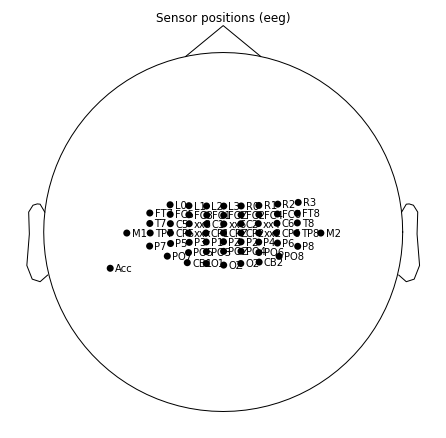

The sensor locations in 3D:


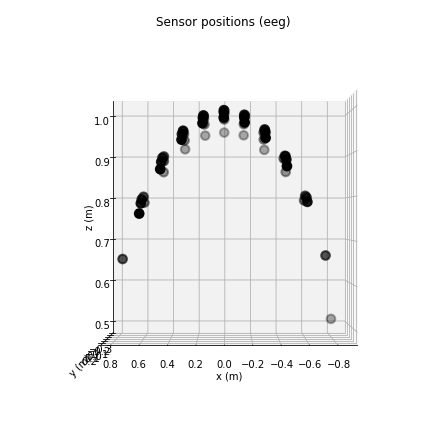

In [226]:
##Choose channel to analyze                                                     #Please input the desired channel name
ch_choice = ['C1']
#Choose the times below. We will crop the file in this  window.
time_secs = raw.times
start_stop_seconds = np.array([25, 25.5])                    #Please select start and end crop times in seconds
dpi = 50 #for matplotlib figures

##Import metadata to internal variables
n_time_samps = raw.n_times
time_secs = raw.times
ch_names = raw.ch_names
n_chan = len(ch_names)
sampling_rate= raw.info['sfreq']
dt=1/sampling_rate

#finds the index for the chosen channel
ranger=np.arange(1,n_chan);
for i in ranger:
  if ch_names[i]==ch_choice[0]:
       index_channel=i
  else:
       pass

## Print some metadata
print('the imported data object has {} time samples and {} channels.'
''.format(n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print()  # insert a blank line in the output
print('sampling frequency is {}'.format(sampling_rate, 'Hz'))           
print('MISC INFO: {}'.format(raw.info['description'], '\n')) #misc  info

print(raw.info)
print() #adding an extra row 
print() 
print()
print()

print('The sensor locations on the cranium:')
raw.plot_sensors(show_names=True);
print('The sensor locations in 3D:')
raw.plot_sensors('3d');

## Crop the time window and load to RAM:

In [227]:
#Cropping the file based on the times provided in cell4, line5.
raw_select = raw.copy()
raw_select.crop(tmin=start_stop_seconds[0], tmax=start_stop_seconds[1], include_tmax=True).load_data();
raw_select.pick_channels(ch_choice);
#start_sample, stop_sample = (start_stop_seconds * sampling_rate).astype(int)
times=np.arange(start_stop_seconds[0],start_stop_seconds[1],dt)

#extracting some internal variables from above input
duration_selection = start_stop_seconds[1]-start_stop_seconds[0]
start_sample, stop_sample = (start_stop_seconds * sampling_rate).astype(int)
times=np.arange(start_stop_seconds[0],start_stop_seconds[1],dt)
lsel=len(times)
times=times.reshape(1,lsel)

#printing some metadata
print('We will use the timewindow of {} to {} seconds.'.format(start_stop_seconds[0],start_stop_seconds[1]))
print('this is equal to {} milliseconds in length'.format(duration_selection*1000))
print('this is equal to {} datapoints in length'.format(lsel))

Reading 0 ... 2500  =      0.000 ...     0.500 secs...
We will use the timewindow of 25.0 to 25.5 seconds.
this is equal to 500.0 milliseconds in length
this is equal to 2500 datapoints in length


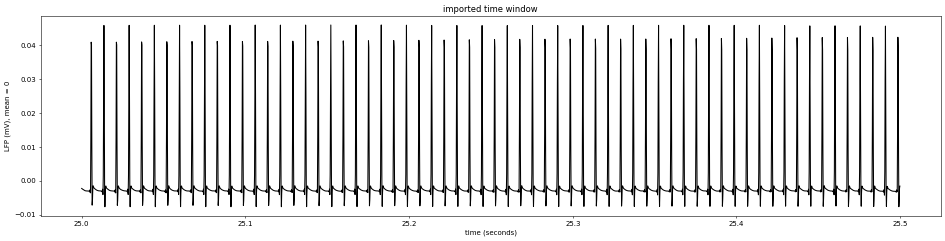

In [228]:
#imports the selected window to a NumPy Array
raw_selection = list(raw[2, start_sample:stop_sample]);
x = raw_selection[1].reshape(lsel,);
y = raw_selection[0].T;
y = np.mean(y) - y
y = y.reshape(lsel,)
#print('Quality control:')
#print(x.shape)
#print(y.shape)

## Setting the matplotlib variables:                                            # Modify the matplotlib vars which will be used throughout the notebook
#if duration_selection <= 10:                                                   Used for very wide sections. e.g. whole trial
#  figwid = duration_selection*10
#else:
#    figwid=1

mpdims = [0, 0, 3, 1]


fig = plt.figure(dpi=dpi);
axes=fig.add_axes(mpdims);
axes.plot(x, y, c='k');
axes.set_facecolor('white')
axes.set_title('imported time window')
axes.set_ylabel('LFP (mV), mean = 0')
axes.set_xlabel('time (seconds)')
axes.autoscale_view(tight=True)

## Find the peaks:

0.04593907165527343
0.022969535827636715

Average stimulation frequency in the imported window is 2.5491595617014267 Hz

Maximum distance between the stimulations is 125029.0 datapoints
Mean distance between the stimulations is 125029.0 datapoints



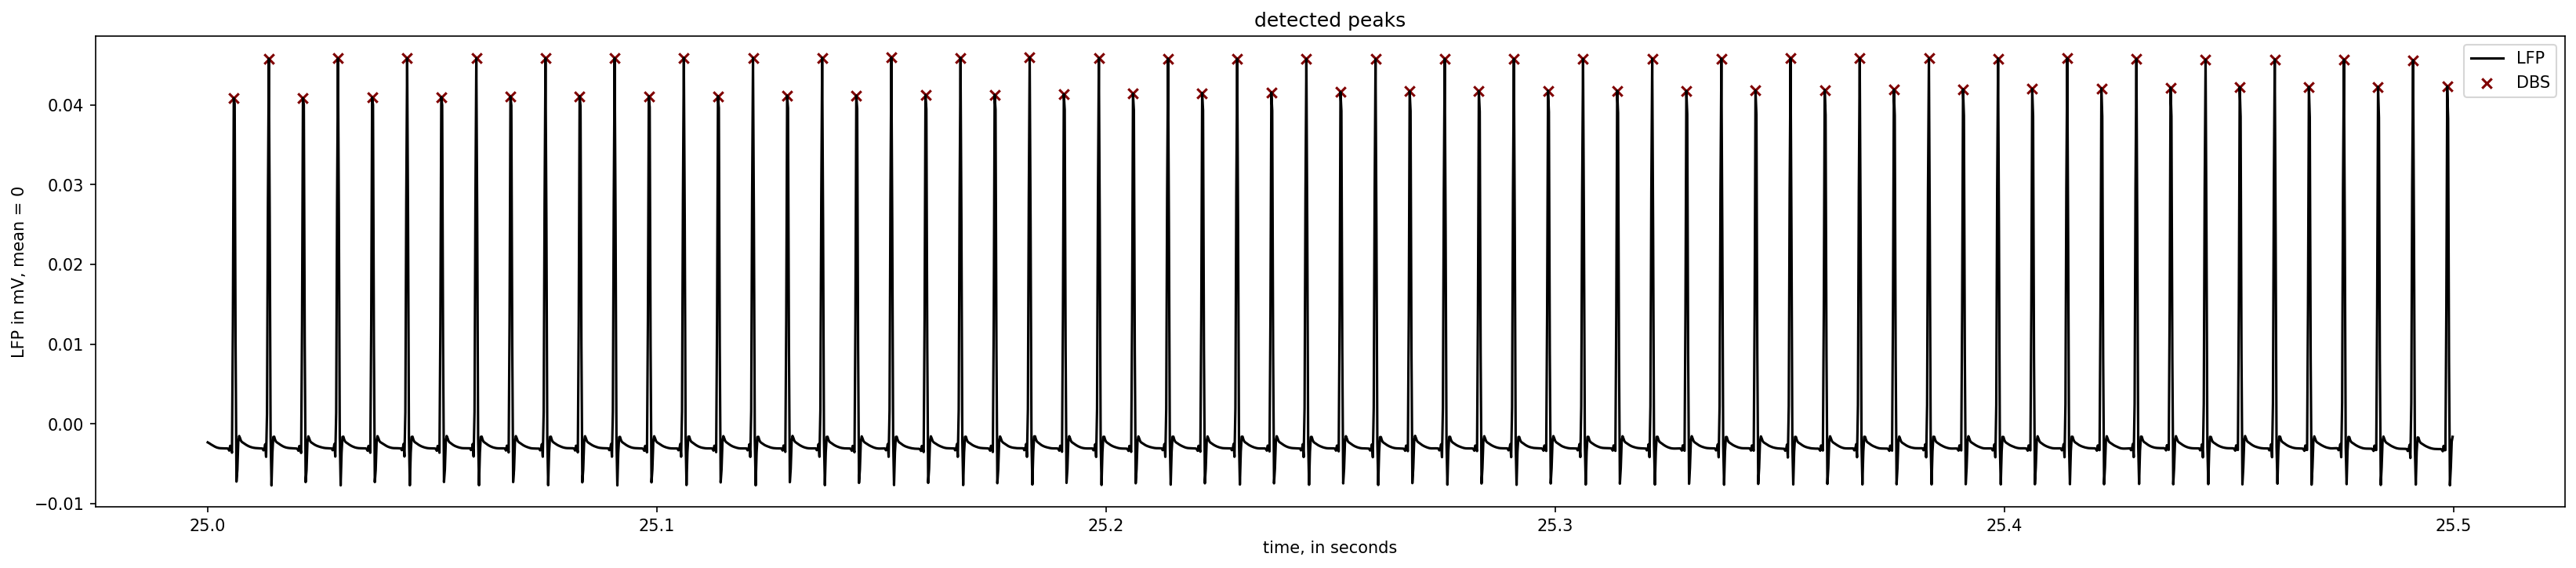

In [229]:
amp_max=max(y)
amp_th=amp_max/2
print(amp_max)
print(amp_th)

pkfinder=sg.find_peaks(y, height=(amp_th))
pkpt=pkfinder[0]

indx_pks, pks = pkfinder[0]*dt+start_stop_seconds[0], pkfinder[1]['peak_heights']
lstim=len(indx_pks)

# x must be the indx_pks array when time is defined in seconds
def stim_avg_freq(x):
  x1 = np.insert(x,0,0)
  x1 = np.delete(x1,-1)
  dist = x - x1
  return 1/np.mean(dist)

def stim_max_dist(x):
  x1 = np.insert(x,0,0)
  x1 = np.delete(x1,-1)
  dist = x - x1
  return np.max(dist)

stim_max_dist = stim_max_dist(indx_pks)

stim_avg_freq=stim_avg_freq(indx_pks)

print()
print('Average stimulation frequency in the imported window is {} Hz'.format(
    stim_avg_freq
))
print()
print('Maximum distance between the stimulations is {} datapoints'.format(
    stim_max_dist*sampling_rate
))
print('Mean distance between the stimulations is {} datapoints'.format(
    stim_max_dist*sampling_rate
))


print()
#print(indx_pks.shape) #Quality Check
#print(pks.shape)
#print()
#print(indx_pks)
#print()
#print(pks)


##Change events into MNE format, will be stored in i, for possible use           #uncomment for use:
#sp_data = pkfinder[0].reshape(1,len(indx_pks)) #i = np.append(
    #pkfinder[0].reshape(len(indx_pks),1), np.zeros((len(indx_pks),2), int),
    #axis=1)
#print(sp_data.shape)

dpi =150
fig1 = plt.figure(dpi=dpi);
#plt.savefig(fname='/content/drive/My Drive/research/nsbspl/figures/cep/{}_selected_window.png'.format(datetime.now()))
axes=fig1.add_axes([0,0,3.5,1]);
axes.plot(x, y, c='k', label='LFP');
axes.scatter(indx_pks, pks, marker='x', c='maroon', label='DBS');
axes.set_title('detected peaks');
axes.set_facecolor('white');
axes.set_ylabel('LFP in mV, mean = 0');
axes.set_xlabel('time, in seconds');
axes.autoscale_view(tight=True, scalex=True, scaley=True);
axes.legend(('LFP', 'DBS'))
plt.show()

In [0]:
## Making an MNE stim channel out of the found peaks

"""

Uncomment to use. in this notebook, we will just use the numpy array and
manipulate it using numpy,scipy,etc.

""";

#stim_data = np.zeros((1, lsel+1))[0]
#print(stim_data)

#for j in range(1,lstim):
#  stim_data[pkfinder[0][j]] = pks[j]
#stim_data=stim_data.reshape(1,lsel+1)

#print() #1-line gap
#print(stim_data.shape)   # Quality Control
#print(len(indx_pks))    # Quality Control
#print(len(pkfinder[0])) # Quality Control

#stim_info = mne.create_info(['STI'], sfreq=sampling_rate)
#stim_raw = mne.io.RawArray(stim_data, stim_info)
#raw_select.add_channels([stim_raw], force_update_info=True)
#raw_select.set_channel_types({'STI':'stim'})


the length of template is 25005.8 datapoints equivalent to 40 milliseconds



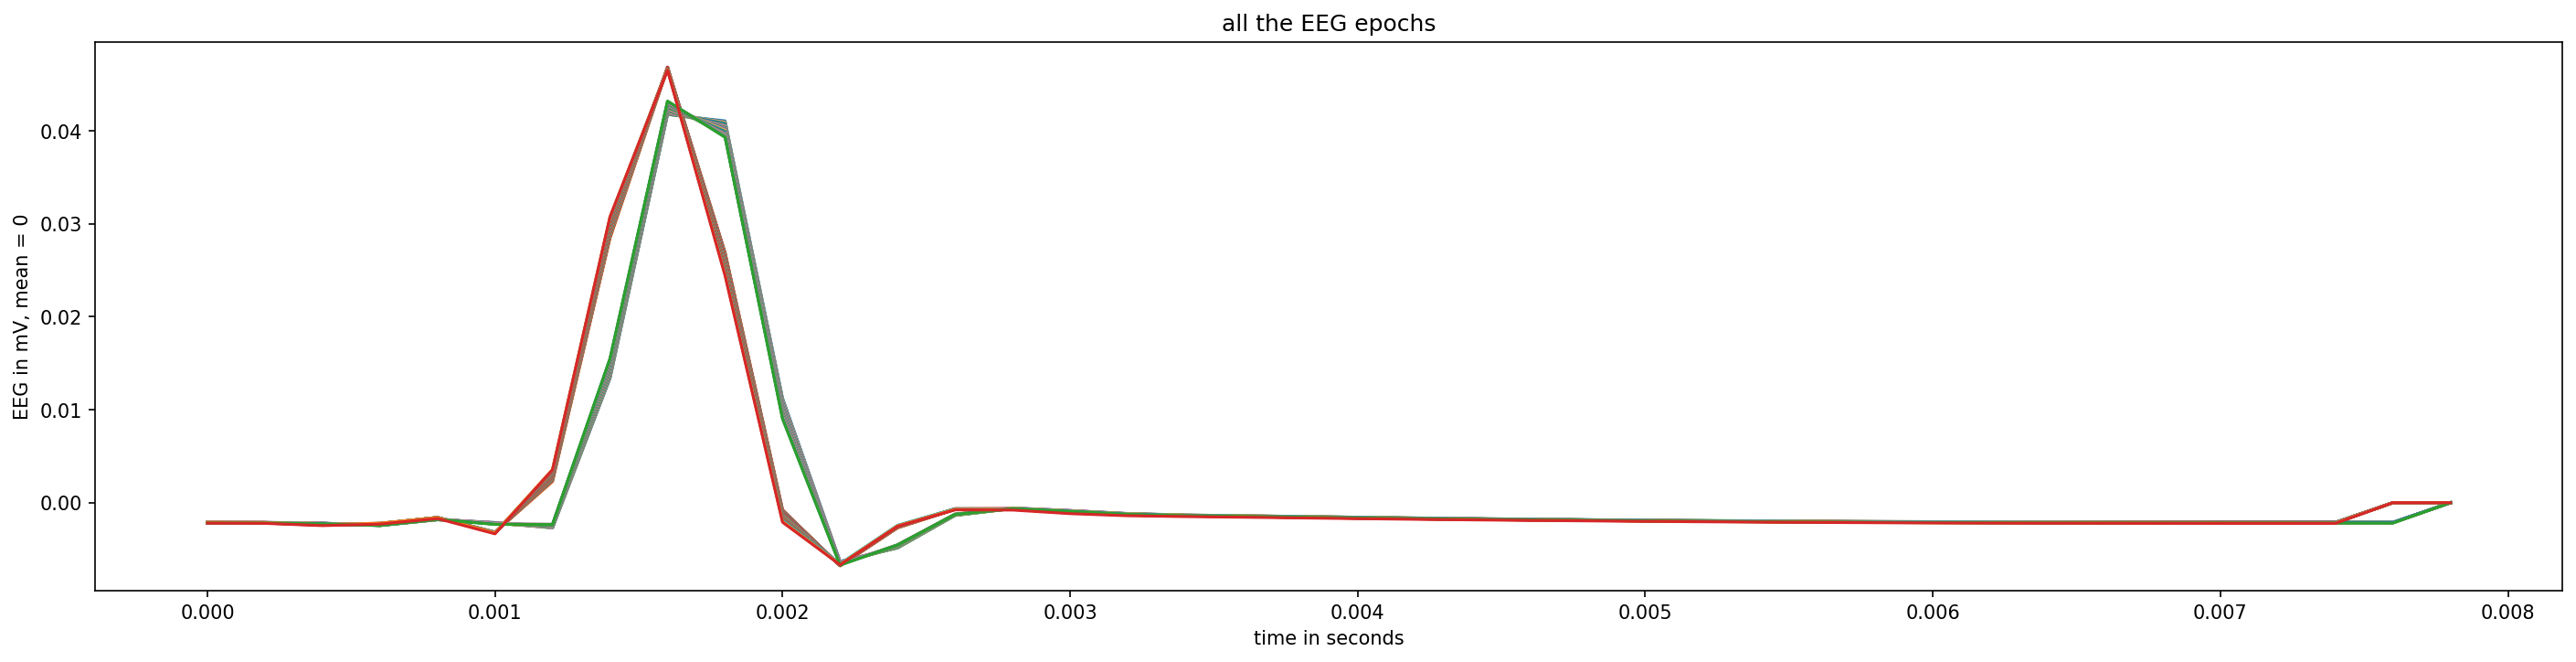

In [231]:
##Cutter: cuts the templates into a (epoch number * amplitude) matrix 

temp_len = 40 # length of each template (in datapoints)
temp_times = (np.arange(0,temp_len)*dt)
shift_left = 8                                                                   # set the number of datapoints you want the template to be shifted to left

print()
print('the length of template is {} datapoints equivalent to {} milliseconds'.format(
    stim_max_dist*1e3,temp_len))
print()

def cutter(x):
  eps = np.zeros((lstim,temp_len,1),dtype=float)
  for i in range(lstim-1):
    diff = pkpt[i+1]-pkpt[i]
    eps[i,0:diff]=x[pkpt[i]-shift_left:pkpt[i]+diff-shift_left]
  return eps*(-1)

eg = list(raw[2, start_sample:stop_sample])[0].T;
eps = cutter(eg)

# Plotting all the epochs:
fig_eps = plt.figure(dpi=dpi);
axes_eps=fig_eps.add_axes([0, 0, 3, 1]);
for i in range(len(eps)-1):
  axes_eps.plot(temp_times, eps[i]);

axes_eps.set_title('all the EEG epochs')
axes_eps.set_facecolor('white')
axes_eps.set_ylabel('EEG in mV, mean = 0')
axes_eps.set_xlabel('time in seconds')
axes_eps.autoscale_view(tight=True, scalex=True, scaley=True)
fig_eps.show(warn=False)

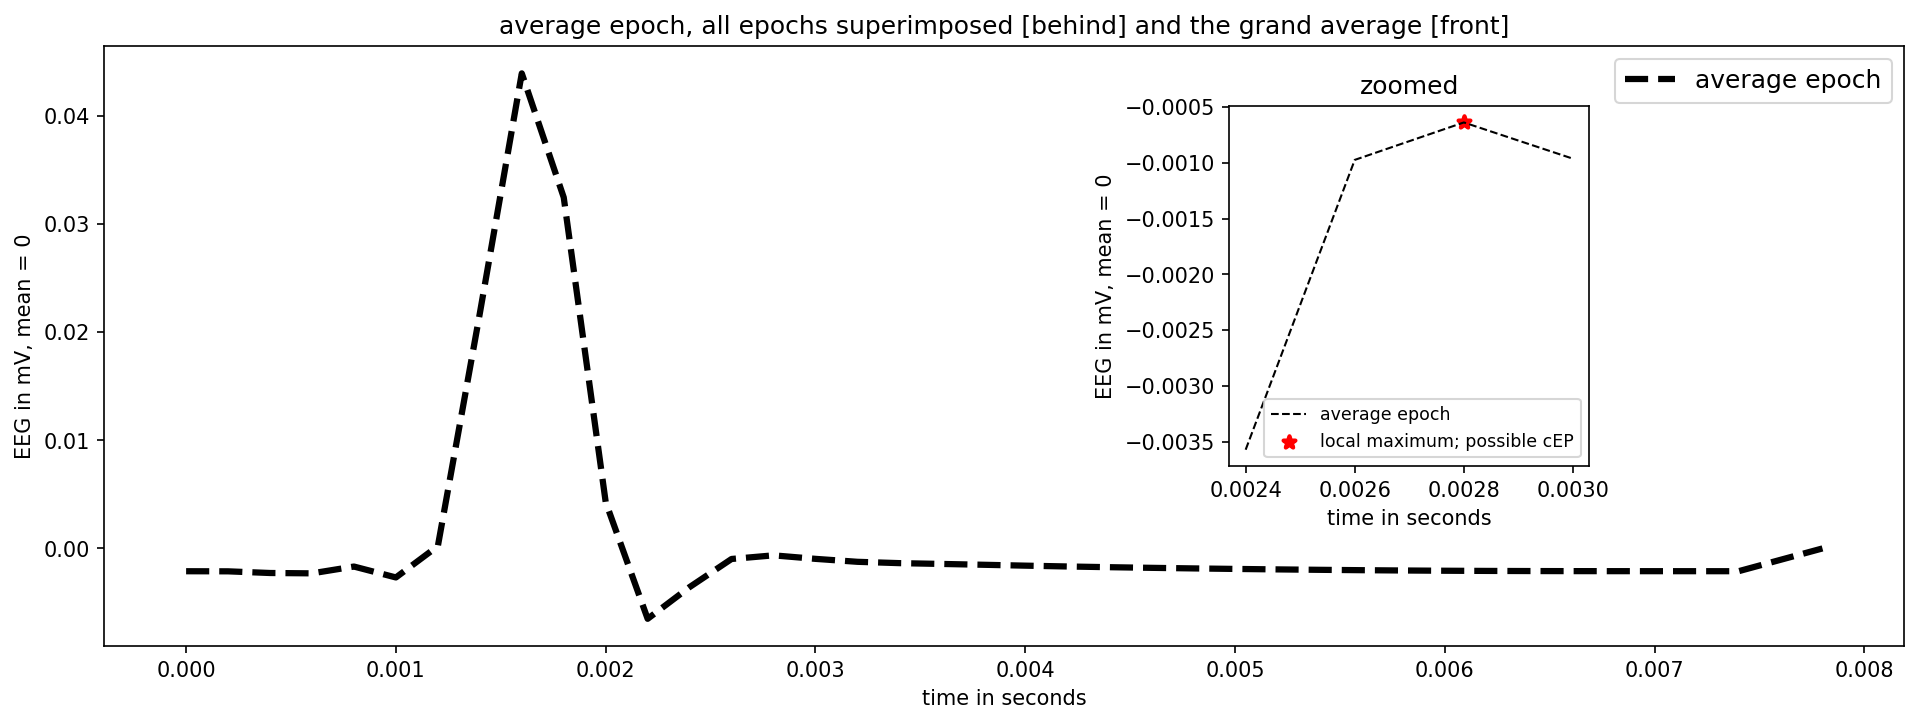

In [232]:
#average all the windows to build a 

avg_temp = np.sum(eps, axis=0)/lstim


fig_avg = plt.figure(dpi=dpi)
axes_avg = fig_avg.add_axes([0,0,2,1])
#for i in range(len(eps)-1):
  #alleps = axes_avg.plot(temp_times, eps[i], linewidth=0.1)
avgline = axes_avg.plot(temp_times, avg_temp, c='k', label='average epoch', ls='--' ,lw=3)
axes_avg.set_title('average epoch, all epochs superimposed [behind] and the grand average [front]')
axes_avg.set_facecolor('white')
axes_avg.set_ylabel('EEG in mV, mean = 0')
axes_avg.set_xlabel('time in seconds')
axes_avg.autoscale_view(tight=True, scalex=True, scaley=True)
axes_avg.legend(loc=0, fontsize='large')

axes_avg = fig_avg.add_axes([1.25,0.3,0.4,0.6])
axes_avg.scatter([0.00280],avg_temp[14], linewidths=2, c='r', marker='*', label='local maximum; possible cEP')
axes_avg.plot((np.arange(12,16))*dt, avg_temp[12:16], c='k', label='average epoch', lw=1, ls='--')
axes_avg.set_title('zoomed')
axes_avg.set_facecolor('White')
axes_avg.set_ylabel('EEG in mV, mean = 0')
axes_avg.set_xlabel('time in seconds')
axes_avg.autoscale_view(tight=True, scalex=True, scaley=True)
axes_avg.legend(loc=0, fontsize='small')

fig_avg.show()

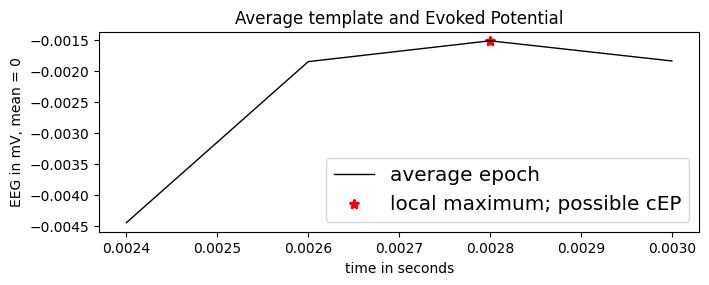

In [233]:
avg_temp = avg_temp - np.mean(avg_temp)
fig_avg = plt.figure(dpi=100)
axes_avg = fig_avg.add_axes([0,0,1,0.5])
axes_avg.scatter([0.00280],avg_temp[14], linewidths=2, c='r', marker='*', label='local maximum; possible cEP')
axes_avg.plot((np.arange(12,16))*dt, avg_temp[12:16], c='k', label='average epoch', lw=1)
axes_avg.set_title('Average template and Evoked Potential')
axes_avg.set_facecolor('White')
axes_avg.set_ylabel('EEG in mV, mean = 0')
axes_avg.set_xlabel('time in seconds')
axes_avg.autoscale_view(tight=True, scalex=True, scaley=True)
axes_avg.legend(loc=0, fontsize='x-large')

fig_avg.show()

In [234]:
print(avg_temp)

[[-0.00298147]
 [-0.00299065]
 [-0.00314475]
 [-0.00317655]
 [-0.00254798]
 [-0.00355666]
 [-0.0006607 ]
 [ 0.020851  ]
 [ 0.04304218]
 [ 0.031575  ]
 [ 0.00341037]
 [-0.00737951]
 [-0.00444634]
 [-0.00184825]
 [-0.00151254]
 [-0.0018375 ]
 [-0.00211002]
 [-0.00223332]
 [-0.00230653]
 [-0.00238374]
 [-0.00246545]
 [-0.00254139]
 [-0.00260808]
 [-0.00266711]
 [-0.00272033]
 [-0.00276839]
 [-0.00281165]
 [-0.00285035]
 [-0.00288422]
 [-0.0029128 ]
 [-0.00293573]
 [-0.00295278]
 [-0.00296431]
 [-0.0029712 ]
 [-0.00297468]
 [-0.00297644]
 [-0.00297792]
 [-0.00297967]
 [-0.00192589]
 [-0.00087364]]


## Plot the Power Spectrum after stimulation:

Reading 0 ... 913599  =      0.000 ...   182.720 secs...
Setting up low-pass filter at 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hann window with 0.0546 passband ripple and 44 dB stopband attenuation
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 775 samples (0.155 sec)



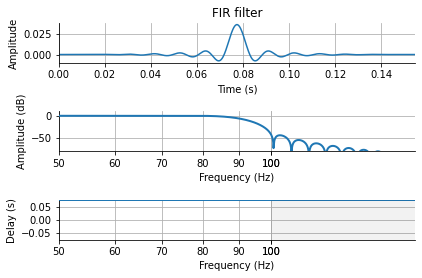

In [235]:
raw2 = raw.copy().load_data() #.pick_channels(ch_choice);

filter_params = mne.filter.create_filter(raw2._data[1],
  sfreq=sampling_rate, fir_window='hann', l_freq=0, h_freq=80, method='fir');
mne.viz.plot_filter(filter_params, sampling_rate, flim=(50, 160));

this is the shape of an ideal filter to remove the 130 Hz artifact and beyond



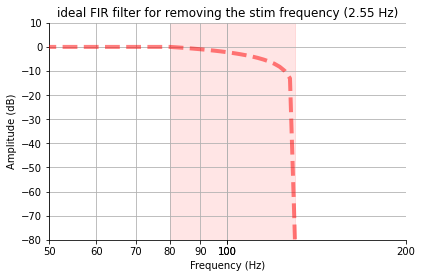

In [236]:
freq = [0, 10, 80, 130]; #starts the fir 30 Hz before the stim frequency
gain = [1, 1, 1, 0];                                                                                       #   <<==  choose FIR filter params here

print('this is the shape of an ideal filter to remove the {} Hz artifact and beyond'
.format(freq[3]))
print()

mne.viz.plot_ideal_filter(freq, gain, flim=(50, 200), title='ideal FIR filter for removing the stim frequency ({} Hz)'.format(round(stim_avg_freq,2)));

Effective window size : 1.638 (s)


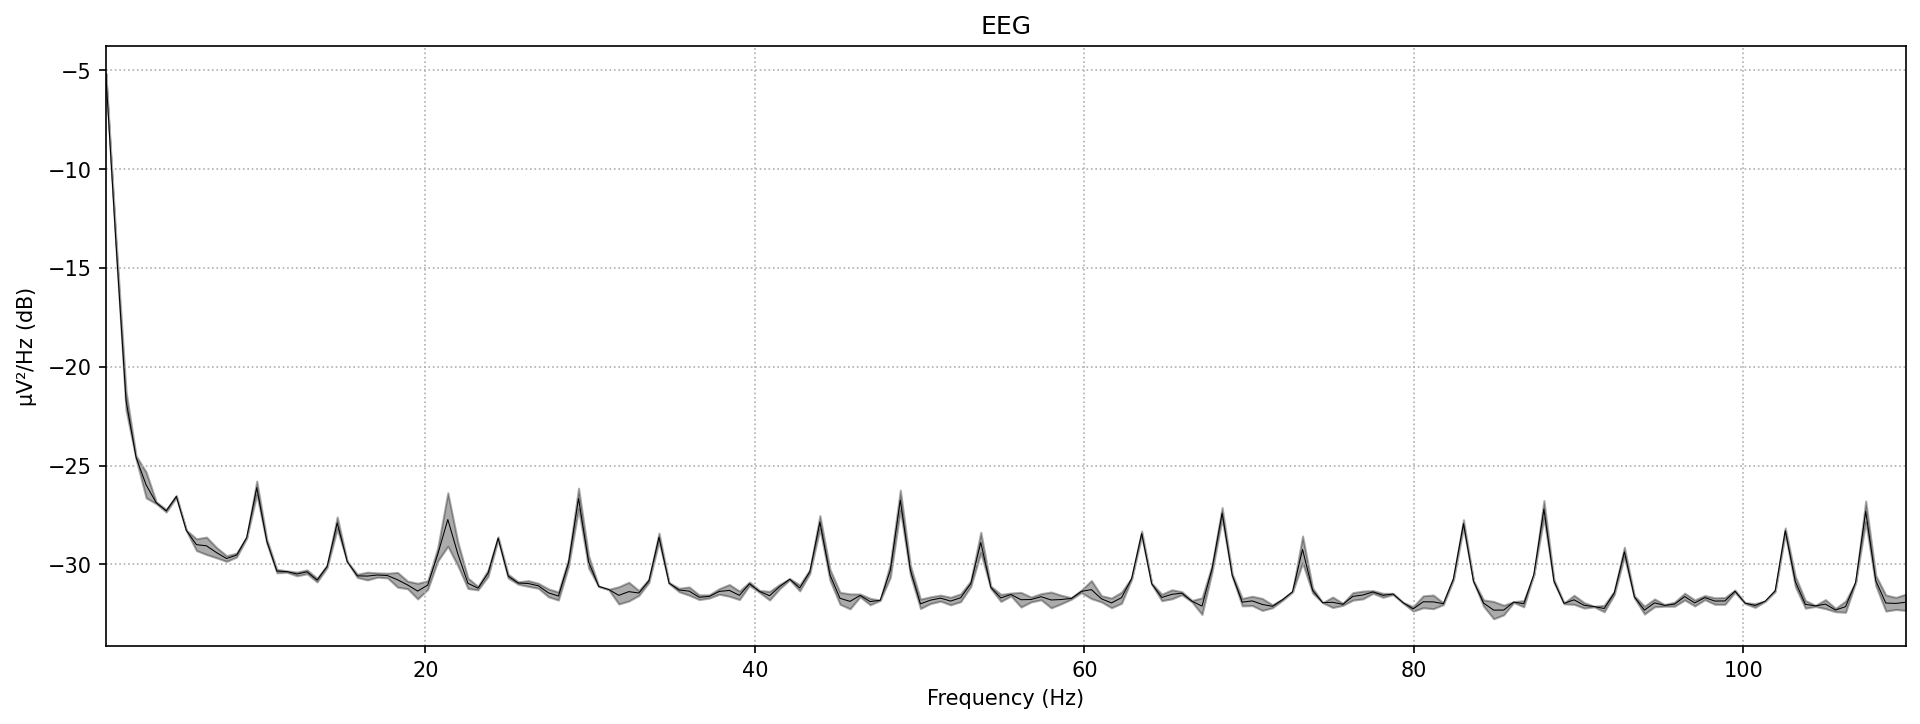

In [237]:
fig_psd = plt.figure(dpi=dpi);
axes_psd = fig_psd.add_axes([0,0,2,1]);

"""in the STN-OFF file, the L1 channel is very low freq. activity.
It might have had bad wiring/connectivity.""";

picks_psd = ['C1', 'C2', 'FP1', 'FP2'];
raw.plot_psd(ax=axes_psd, fmax= 110, color='k', estimate='power', n_fft=8192,
             picks=picks_psd, average=True, n_overlap = 4096, fmin = 0.1);

plt.show()